# EDA

In this notebook, I will conduct exploratory data analysis on the outage dataframe compiled in the data wrangling notebook. As part of EDA, I may import new data as needed to enhance the data set.

In [1]:
# Import necessary modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import json
import requests
import statistics
import time
import warnings

### Incorporate new datasource for energy demand and generation
I found another data source for energy demand and generation that should have less null values.  However, it does not provide data on a daily basis, only by month, so it has less specificity than the previous data set.  The benefits gained by having less null values are greater than the drawbacks due to the lack of specificity.  Therefore I will incorporate this new data into the dataframe.  The new data comes from the North American Electric Reliability Corporation (NERC) and is located here: https://www.nerc.com/pa/RAPA/ESD/Pages/default.aspx

In [81]:
warnings.filterwarnings('ignore')

# Import and clean  energy generation data
energy_generation_df = pd.read_excel('./Raw-Data/2023_ESD.xlsx',sheet_name = 'NEL-Monthly')
energy_generation_df

# Use melt() method to convert from wide to long form for the month columns
energy_generation_df = energy_generation_df.melt(id_vars = ['Report Year', 'Country', 'Region', 'Subregion', 'Assessment Area', 'Unit', 'Description'], value_vars = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
       'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], var_name = ['Month'], value_name = 'Monthly Net Energy for Load (GWh)')

# For years before 2023, I only care about the actual numbers, so I will drop those rows associated with forecasts.
# Also, for the actual numbers, each row actually describes the NEL for the PRIOR year, so I will substract one year from  the 'Report Year' column.
energy_generation_df_before2023 = energy_generation_df[~energy_generation_df['Description'].str.contains('Forecast')]
energy_generation_df_before2023['Report Year'] = energy_generation_df['Report Year'] - 1
energy_generation_df_before2023['Description'] = energy_generation_df_before2023['Description'].str.replace('Prior Year Actual', 'Year Actual') # Since I changed the 'Report Year' column to reflect the prior year, I will modify the description to reflect this change
energy_generation_df_before2023

# For the year 2023, I will use the forecasts for Net Energy Load
energy_generation_df_2023 = energy_generation_df[energy_generation_df['Report Year'] == 2023][energy_generation_df['Description'].str.contains('Reporting Year Forecast')]
energy_generation_df_2023

# The FRCC region stopped reporting in 2018, so this data needs to be treated a bit differently.  I will incorporate that data in the code below
energy_generation_FRCC = energy_generation_df[(energy_generation_df['Region'] == 'FRCC') & (energy_generation_df['Report Year'] >= 2018) & (~energy_generation_df['Month'].str.contains('Jan|Feb|Mar'))]
energy_generation_FRCC = energy_generation_FRCC[~energy_generation_FRCC['Description'].str.contains('Prior Year Actual')]
energy_generation_FRCC.loc[energy_generation_FRCC['Description'].str.contains('Year 1 Forecast'), 'Report Year'] += 1
energy_generation_FRCC

# The SPP RE region stopped reporting in 2019, so this data needs to be treated a bit differently.  I will incorporate that data in the code below
energy_generation_SPP = energy_generation_df[(energy_generation_df['Region'] == 'SPP-RE') & (energy_generation_df['Report Year'] >= 2019)]
energy_generation_SPP = energy_generation_SPP[~energy_generation_SPP['Description'].str.contains('Prior Year Actual')]
energy_generation_SPP.loc[energy_generation_SPP['Description'].str.contains('Year 1 Forecast'), 'Report Year'] += 1
energy_generation_SPP

# I will combine the 'before2023' df with the '2023' df back into the same df
energy_generation_df = pd.concat([energy_generation_df_before2023, energy_generation_df_2023, energy_generation_FRCC, energy_generation_SPP])
energy_generation_df

# I will rename the column 'Report Year' to 'Year' as it is a more accurate description of the values in the column and reset the index
energy_generation_df.rename(columns = {'Report Year':'Year'}, inplace = True)
energy_generation_df.reset_index(drop = True, inplace = True)
energy_generation_df

# Convert the year and month column into a datetime column
energy_generation_df['Datetime (Month/Year)'] = pd.to_datetime(energy_generation_df['Month'] + energy_generation_df['Year'].astype(str))
energy_generation_df['Year'] = energy_generation_df['Datetime (Month/Year)'].dt.year
energy_generation_df['Month'] = energy_generation_df['Datetime (Month/Year)'].dt.month
energy_generation_df['Monthly Net Energy for Load (GWh)'] = pd.to_numeric(energy_generation_df['Monthly Net Energy for Load (GWh)']) # Converts this column from string to float

# This code group the data by region and month/year and sums the peak demand across those groupings to come up with a single value
energy_generation_df = pd.DataFrame(energy_generation_df.groupby(['Region', 'Year', 'Month'])['Monthly Net Energy for Load (GWh)'].sum()).reset_index()
energy_generation_df

# The code below aligns the spelling of the NERC regions to the outage_df nomenclature
energy_generation_df['Region'] = energy_generation_df['Region'].str.replace('SPP-RE','SPP RE')
energy_generation_df['Region'] = energy_generation_df['Region'].str.replace('TRE-ERCOT', 'TRE')
energy_generation_df[(energy_generation_df['Region'].str.contains('WECC')) & (energy_generation_df['Year']>2021)]


,Region,Year,Month,Monthly Net Energy for Load (GWh)
2790,WECC,2022,1,76705.698484
2791,WECC,2022,2,67288.359992
2792,WECC,2022,3,70160.970234
2793,WECC,2022,4,66947.551070
2794,WECC,2022,5,70613.766732
2795,WECC,2022,6,76290.636181
2796,WECC,2022,7,87239.354945
2797,WECC,2022,8,86540.862673
2798,WECC,2022,9,76429.902487
2799,WECC,2022,10,69928.167877


In [76]:
# Import and clean energy demand data
energy_demand_df = pd.read_excel('./Raw-Data/2023_ESD.xlsx',sheet_name = 'Peak Hour Demand-Monthly')
energy_demand_df

# Use melt() method to convert from wide to long form for the month columns
energy_demand_df = energy_demand_df.melt(id_vars = ['Report Year', 'Country', 'Region', 'Subregion', 'Assessment Area', 'Unit', 'Description'], value_vars = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
       'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], var_name = ['Month'], value_name = 'Monthly Peak Hour Demand (MW)')
energy_demand_df

# For years before 2023, I only care about the actual numbers, so I will drop those rows associated with forecasts.
# Also, for the actual numbers, each row actually describes the demand for the PRIOR year, so I will substract one year from  the 'Report Year' column.
energy_demand_df_before2023 = energy_demand_df[~energy_demand_df['Description'].str.contains('Forecast')]
energy_demand_df_before2023['Report Year'] = energy_demand_df['Report Year'] - 1
energy_demand_df_before2023['Description'] = energy_demand_df_before2023['Description'].str.replace('Prior Year Actual', 'Year Actual') # Since I changed the 'Report Year' column to reflect the prior year, I will modify the description to reflect this change
energy_demand_df_before2023 = energy_demand_df_before2023[~energy_demand_df_before2023['Description'].str.contains('Reporting Year Actual')] # Some rows contain actual data for the reporting year.  This is duplicative of the prior year actual rows, so will be dropped.
energy_demand_df_before2023

# For the year 2023, I will use the reporting year actuals (where available) and forecasts for Peak Hour Demand
energy_demand_df_2023_actual = energy_demand_df[energy_demand_df['Report Year'] == 2023][energy_demand_df['Description'].str.contains('Reporting Year Actual')]
energy_demand_df_2023_actual.dropna(subset = 'Monthly Peak Hour Demand (MW)', inplace = True)
energy_demand_df_2023_actual

energy_demand_df_2023_forecast = energy_demand_df[(energy_demand_df['Report Year'] == 2023) & (energy_demand_df['Month']!= 'Jan') & (energy_demand_df['Month']!= 'Feb')][energy_demand_df['Description'].str.contains('Reporting Year Forecast')]
energy_demand_df_2023_forecast.dropna(subset = 'Monthly Peak Hour Demand (MW)', inplace = True) # There is one null value that will be dropped. This value is null because there is an actual value in the dataset
energy_demand_df_2023_forecast

# The FRCC region stopped reporting in 2018, so this data needs to be treated a bit differently.  I will incorporate that data in the code below
energy_demand_FRCC = energy_demand_df[(energy_demand_df['Region'] == 'FRCC') & (energy_demand_df['Report Year'] >= 2018) & (~energy_demand_df['Month'].str.contains('Jan|Feb|Mar'))]
energy_demand_FRCC = energy_demand_FRCC[~energy_demand_FRCC['Description'].str.contains('Prior Year Actual')]
energy_demand_FRCC.loc[energy_demand_FRCC['Description'].str.contains('Year 1 Forecast'), 'Report Year'] += 1
energy_demand_FRCC


# The SPP RE region stopped reporting in 2019, so this data needs to be treated a bit differently.  I will incorporate that data in the code below
energy_demand_SPP = energy_demand_df[(energy_demand_df['Region'] == 'SPP-RE') & (energy_demand_df['Report Year'] >= 2019)]
energy_demand_SPP = energy_demand_SPP[~energy_demand_SPP['Description'].str.contains('Prior Year Actual')]
energy_demand_SPP.loc[energy_demand_SPP['Description'].str.contains('Year 1 Forecast'), 'Report Year'] += 1
energy_demand_SPP

# I will combine the 'before2023' df with the '2023' df back into the same df
energy_demand_df = pd.concat([energy_demand_df_before2023, energy_demand_df_2023_actual, energy_demand_df_2023_forecast, energy_demand_FRCC, energy_demand_SPP])
energy_demand_df

# I will rename the column 'Report Year' to 'Year' as it is a more accurate description of the values in the column and reset the index
energy_demand_df.rename(columns = {'Report Year':'Year'}, inplace = True)
energy_demand_df.reset_index(drop = True, inplace = True)
energy_demand_df

# Convert the year and month column into a datetime column, drop unnecessary columns
energy_demand_df['Datetime (Month/Year)'] = pd.to_datetime(energy_demand_df['Month'] + energy_demand_df['Year'].astype(str))
energy_demand_df['Year'] = energy_demand_df['Datetime (Month/Year)'].dt.year
energy_demand_df['Month'] = energy_demand_df['Datetime (Month/Year)'].dt.month
energy_demand_df.drop(index = 525, inplace = True) # Drops a row in which there is no demand data, this is in 2015, so will not affect the ultimate dataset
energy_demand_df['Monthly Peak Hour Demand (MW)'] = pd.to_numeric(energy_demand_df['Monthly Peak Hour Demand (MW)']) # Converts this column from string to float

# This code group the data by region and month/year and sums the peak demand across those groupings to come up with a single value
energy_demand_df = pd.DataFrame(energy_demand_df.groupby(['Region', 'Year', 'Month'])['Monthly Peak Hour Demand (MW)'].sum()).reset_index()

# The code below aligns the spelling of the NERC regions to the outage_df nomenclature
energy_demand_df['Region'] = energy_demand_df['Region'].str.replace('SPP-RE','SPP RE')
energy_demand_df['Region'] = energy_demand_df['Region'].str.replace('TRE-ERCOT', 'TRE')
energy_demand_df[(energy_demand_df['Region'].str.contains('WECC')) & (energy_demand_df['Year'] >= 2022)]

,Region,Year,Month,Monthly Peak Hour Demand (MW)
2790,WECC,2022,1,108372.011913
2791,WECC,2022,2,106953.910952
2792,WECC,2022,3,101781.876097
2793,WECC,2022,4,103253.601483
2794,WECC,2022,5,112713.702565
2795,WECC,2022,6,130749.667701
2796,WECC,2022,7,140981.491113
2797,WECC,2022,8,140254.567653
2798,WECC,2022,9,135690.751230
2799,WECC,2022,10,110898.089444


In [256]:
# Commenting out the below code so it doesn't overwrite the outage_df inadvertently!
'''# Bring in the dataframe created in the data wrangling notebook
outage_df = pd.read_csv('outage_df.csv')
outage_df['Datetime Event Began'].fillna(outage_df['Datetime of Restoration'], inplace = True) # Replaces missing values in 'Datetime Event Began' column with the value stored in 'Datetime of Resortation' column
outage_df.drop(columns = ['Unnamed: 0', 'State Daily Energy Demand (MWh)'], inplace = True) # Drops an unnamed and unnecessary column
outage_df.drop(columns = ['Datetime of Restoration', 'Area Affected'], inplace = True)
outage_df['Datetime Event Began'] = pd.to_datetime(outage_df['Datetime Event Began']) # Converts datetime column to datetime type to facilitate merge


# The code below combines the energy generation and demand data into the outage_df imported from the data wrangling notebook
# Prepare outage_df and energy dfs to be merged. Creating new year/months columns in each df to merge
outage_df['Year'] = outage_df['Datetime Event Began'].dt.year
outage_df['Month'] = outage_df['Datetime Event Began'].dt.month

# Some of the evnets affect multiple NERC regions. For these cases, I will use the energy demand and generation from the first region listed
outage_df['NERC Region'] = outage_df['NERC Region'].str.split('/').str[0]

# Merge energy_generation_df into the outage_df on year, month, and region
outage_df = outage_df.merge(energy_generation_df, left_on = ['NERC Region', 'Year', 'Month'], right_on = ['Region','Year', 'Month'], how = 'left')
outage_df.drop(columns = ['Region'], inplace = True)

# Merge energy_demand_df into the outage_df on year, month, and region
outage_df = outage_df.merge(energy_demand_df, left_on = ['NERC Region', 'Year', 'Month'], right_on = ['Region','Year', 'Month'], how = 'left')
outage_df.drop(columns = ['Year', 'Month', 'Region'], inplace = True)
outage_df[outage_df['Monthly Peak Hour Demand (MW)'].isna()]

# I wasn't able to get energy data for Puerto Rico, so I am dropping those rows
outage_df = outage_df[outage_df['State Affected'] != 'Puerto Rico']

# For some reason, one row for the energy demand and generation didn't merge.  I will manually update the values
outage_df.loc[389,'Monthly Net Energy for Load (GWh)'] = 70208.588954
outage_df.loc[389,'Monthly Peak Hour Demand (MW)'] = 118128.871300
outage_df[(outage_df['State Avg Temp (F)'].isna()) & (outage_df['State Affected'] == 'Texas')]
'''

"# Bring in the dataframe created in the data wrangling notebook\noutage_df = pd.read_csv('outage_df.csv')\noutage_df['Datetime Event Began'].fillna(outage_df['Datetime of Restoration'], inplace = True) # Replaces missing values in 'Datetime Event Began' column with the value stored in 'Datetime of Resortation' column\noutage_df.drop(columns = ['Unnamed: 0', 'State Daily Energy Demand (MWh)'], inplace = True) # Drops an unnamed and unnecessary column\noutage_df['Datetime Event Began'] = pd.to_datetime(outage_df['Datetime Event Began']) # Converts datetime column to datetime type to facilitate merge\n\n\n# The code below combines the energy generation and demand data into the outage_df imported from the data wrangling notebook\n# Prepare outage_df and energy dfs to be merged. Creating new year/months columns in each df to merge\noutage_df['Year'] = outage_df['Datetime Event Began'].dt.year\noutage_df['Month'] = outage_df['Datetime Event Began'].dt.month\n\n# Some of the evnets affect mu

### Cells below used to import missing weather data

In [94]:
# # There are quite few null values related to weather specifically for Texas. I will pull these again from the API to populate these null values
# # The code below pulls the NOAA API token from a local .env file.  API token can be requested here: https://www.ncdc.noaa.gov/cdo-web/token
# from dotenv import load_dotenv
# load_dotenv()
# token = os.getenv('NOAA_token')
# # print(token) # This checks that the token was pulled correctly

# # Setting a variable "header" equal to the token to be included in the GET request
# headers = {"token": token}

In [212]:
# weather_data_dict

{34: [65.7625],
 37: [50.5925],
 50: [65.02027027027026],
 53: [67.28243243243243],
 58: [70.16972972972974],
 62: [78.9654054054054],
 68: [82.99671232876713],
 77: [87.37189189189189],
 78: [87.37189189189189],
 96: [44.59513513513514],
 123: [76.93675675675675],
 126: [70.86027397260274],
 133: [83.03972972972974],
 135: [81.20324324324324],
 140: [82.71621621621622],
 145: [87.54216216216216],
 155: [82.59216216216217],
 160: [83.04702702702703],
 161: [83.04702702702703],
 163: [83.04702702702703],
 164: [83.04702702702703],
 177: [73.72837837837838],
 201: [48.04189189189189],
 207: [15.206],
 208: [15.206],
 209: [15.206],
 210: [15.206],
 211: [15.206],
 212: [15.206],
 213: [15.206],
 216: [15.206],
 218: [15.206],
 219: [15.206],
 224: [18.726285714285716],
 230: [18.726285714285716],
 239: [79.7744],
 252: [78.8291891891892],
 253: [78.8291891891892],
 261: [76.2454794520548],
 275: [62.26189189189189],
 282: [47.60082191780822],
 293: [34.303513513513515],
 325: [81.3152],


In [228]:
# # For windspeed data

# # Setting request parameters to pull relevant weather data from the API.
# dataset_id = "GHCND" # This id corresponds to the data set with historical daily climate observations. Documentation for this dataset is here: https://www.ncei.noaa.gov/pub/data/ghcn/daily/readme.txt

# # Below are the datatype ids of the specific observations I would like to pull from each event
# avg_temp_datatype_id = "TAVG" # Returns avg temperature for the date and location specified in tenths of degrees Celsius
# avg_wind_speed_datatype_id = "AWND" # Returns avg windspeed for the date/location specified in tenths of meters/second
# precip_datatype_id = "PRCP" # Returns precipitation for date/location in tenths of mm

# # Creating a function for a GET request for weather data for each event in the outage_df. 
# # This code pulls the four datatypes listed above from all weather stations within the affected state, averages them over all the stations, and returns a single value for each datatype which will be incorporated in the outage_df
# def weather_data_request(event_index):
    
#     '''
#     This function will issue a request to the NOAA CDO API for the four parameters described for a specific event in the outage_df.
#     The only argument/parameter needed is the associated index number from the outage_df dataset above.
#     '''
    
#     start_date = outage_df['Datetime Event Began'][event_index].date()   # This will pull the start date from the outage dataset
#     end_date = start_date                                                # The end date should correspond to the start date because we are only interested in the weather at the time the outage occurred
#     location_id = 'FIPS:06'                                              # This pulls the affected state from the outage_df and the associated FIPSID from the FIPSID_dict
#     url_3 = f"https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid={dataset_id}&locationid={location_id}&startdate={start_date}&enddate={end_date}&datatypeid={avg_wind_speed_datatype_id}&limit=1000"

#     max_retries = 3   # This api will often return a 503 error.  Creating a while loop to retry the request 3 times if a 503 error is returned
#     retries = 0
#     while retries <= max_retries:
#         try:
#             r_3 = requests.get(url_3, headers = headers)
#             print(r_3)
#             if r_3.text.strip():
#                 json_data_3 = r_3.json()
#                 dict_data_3 = dict(json_data_3)
#                 # print(dict_data_3)
#                 if dict_data_3 == {}:
#                     return 'No Data'
#                 else:
#                     avg_windspeed_meterspersecond = statistics.mean([dict['value'] for dict in dict_data_3['results'] if dict['datatype']=='AWND'])/10 # divide by 10 to convert to meters per second
#                     avg_windspeed_mph = avg_windspeed_meterspersecond * 2.2369 # converts meters per second to miles per hour  
                    
#                     return [avg_windspeed_mph]
#             else:
#                 return 'No Data'
        
#         except requests.exceptions.HTTPError as e:
#             if response.status_code == 503:
#                 time.sleep(30)
#                 retries += 1
#             else:
#                 time.sleep(10)
#                 retries += 1

# weather_data_dict = {}
# last_index_updated = None

# for index, row in outage_df[outage_df['State Avg Windspeed (mph)'].isna()].iterrows():
#     if last_index_updated is not None and index <= last_index_updated:
#         continue
#     else:
#         weather_data_dict[index] = weather_data_request(index)
#         last_index_updated = index
        
# print(len(weather_data_dict))
# last_index_updated

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
23


372

In [220]:
# # For Temperature Data

# # Setting request parameters to pull relevant weather data from the API.
# dataset_id = "GHCND" # This id corresponds to the data set with historical daily climate observations. Documentation for this dataset is here: https://www.ncei.noaa.gov/pub/data/ghcn/daily/readme.txt

# # Below are the datatype ids of the specific observations I would like to pull from each event
# avg_temp_datatype_id = "TAVG" # Returns avg temperature for the date and location specified in tenths of degrees Celsius
# avg_wind_speed_datatype_id = "AWND" # Returns avg windspeed for the date/location specified in tenths of meters/second
# precip_datatype_id = "PRCP" # Returns precipitation for date/location in tenths of mm

# # Creating a function for a GET request for weather data for each event in the outage_df. 
# # This code pulls the four datatypes listed above from all weather stations within the affected state, averages them over all the stations, and returns a single value for each datatype which will be incorporated in the outage_df
# def weather_data_request(event_index):
    
#     '''
#     This function will issue a request to the NOAA CDO API for the four parameters described for a specific event in the outage_df.
#     The only argument/parameter needed is the associated index number from the outage_df dataset above.
#     '''
    
#     start_date = outage_df['Datetime Event Began'][event_index].date()   # This will pull the start date from the outage dataset
#     end_date = start_date                                                # The end date should correspond to the start date because we are only interested in the weather at the time the outage occurred
#     location_id = 'FIPS:08'                                              # This pulls the affected state from the outage_df and the associated FIPSID from the FIPSID_dict
#     url_3 = f"https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid={dataset_id}&locationid={location_id}&startdate={start_date}&enddate={end_date}&datatypeid={avg_temp_datatype_id}&limit=1000"

#     max_retries = 3   # This api will often return a 503 error.  Creating a while loop to retry the request 3 times if a 503 error is returned
#     retries = 0
#     while retries <= max_retries:
#         try:
#             r_3 = requests.get(url_3, headers = headers)
#             print(r_3)
#             if r_3.text.strip():
#                 json_data_3 = r_3.json()
#                 dict_data_3 = dict(json_data_3)
#                 # print(dict_data_3)
#                 if dict_data_3 == {}:
#                     return 'No Data'
#                 else:
#                     avg_temp_in_C = statistics.mean([dict['value'] for dict in dict_data_3['results'] if dict['datatype']=='TAVG'])
#                     avg_temp_in_F = ((avg_temp_in_C/10)*(9/5))+32 # Converts from tenth degree Celsius to Farenheit 
                    
#                     return [avg_temp_in_F]
#             else:
#                 return 'No Data'
        
#         except requests.exceptions.HTTPError as e:
#             if response.status_code == 503:
#                 time.sleep(30)
#                 retries += 1
#             else:
#                 time.sleep(10)
#                 retries += 1

# weather_data_dict = {}
# last_index_updated = None

# for index, row in outage_df[outage_df['State Avg Temp (F)'].isna()].iterrows():
#     if last_index_updated is not None and index <= last_index_updated:
#         continue
#     else:
#         weather_data_dict[index] = weather_data_request(index)
#         last_index_updated = index
        
# print(len(weather_data_dict))
# last_index_updated

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
4


185

In [230]:
# # For windspeed
# weather_data_df = pd.DataFrame.from_dict(weather_data_dict,orient = 'index',columns = ['State Avg Windspeed (mph)'])
# outage_df.loc[outage_df['State Avg Windspeed (mph)'].isna(), 'State Avg Windspeed (mph)'] = weather_data_df['State Avg Windspeed (mph)'].values
# # outage_df[outage_df['State Affected'] == 'Texas']

In [221]:
# # For temperature
# weather_data_df = pd.DataFrame.from_dict(weather_data_dict,orient = 'index',columns = ['State Avg Temp (F)'])
# outage_df.loc[outage_df['State Avg Temp (F)'].isna(), 'State Avg Temp (F)'] = weather_data_df['State Avg Temp (F)'].values
# # outage_df[outage_df['State Affected'] == 'Texas']

### Visualize the data set

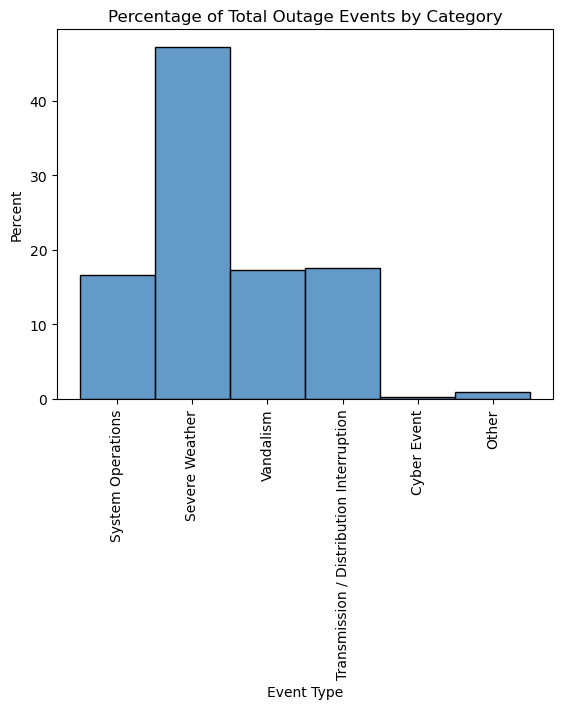

In [336]:
# Lets first look to see how many outage events fall into each "Event Type"
# Some of the event type categories need to be cleaned before we plot them
outage_df['Event Type'].unique()
event_type_mapping = {
    'Fuel Supply Deficiency' : 'System Operations', 
    'Severe Weather' : 'Severe Weather', 
    'System Operations' : 'System Operations',
    'Vandalism' : 'Vandalism', 
    'Transmission Interruption' : 'Transmission / Distribution Interruption', 
    'Sabotage' : 'Vandalism',
    'Transmission Disruption':'Transmission / Distribution Interruption',
    'Severe Weather/Transmission Interruption' : 'Severe Weather', 
    'Natural Disaster':'Severe Weather',
    'Natural Disaster/Transmission Interruption':'Severe Weather',
    'Actual Physical Attack':'Vandalism', 
    'Generation Inadequacy' : 'System Operations',
    'Distribution Interruption':'Transmission / Distribution Interruption',
    'Transmission Interruption/Distribution Interruption' : 'Transmission / Distribution Interruption',
    'Severe Weather/Distribution Interruption' : 'Severe Weather', 
    'Suspicious Activity' : 'Vandalism',
    'Cyber Event' : 'Cyber Event', 
    'Severe Weather/Transmisison Interruption':'Severe Weather',
    'Suspicious activity':'Vandalism', 
    'Actual Physical Attack/Vandalism':'Vandalism',
    '- Vandalism\xa0- Theft':'Vandalism', 
    '- Weather or natural disaster':'Severe Weather',
    '- Transmission equipment failure':'Transmission / Distribution Interruption', 
    '- Other':'Other',
}
outage_df['Event Type'] = outage_df['Event Type'].replace(event_type_mapping)

sns.set_palette('RdBu_r')
# Create the histogram of events by event type
_ = sns.histplot(data = outage_df, x = 'Event Type', stat = 'percent')
plt.xticks(rotation = 90)
plt.title('Percentage of Total Outage Events by Category')
plt.show()

The main culprit of outage events seems to be weather issues.

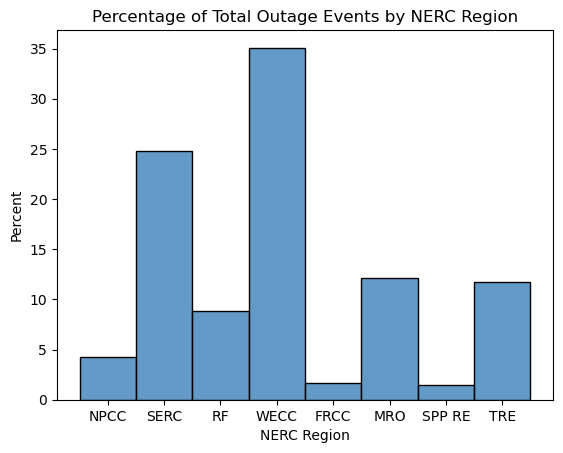

In [337]:
# Let's see if any regions are more likely to have outage events
_ = sns.histplot(data = outage_df, x = 'NERC Region', stat = 'percent')
plt.title('Percentage of Total Outage Events by NERC Region')
plt.show()

WECC accounts for nearly 35% of all outages...perhaps this isn't surprising since it makes up a vast geographic area

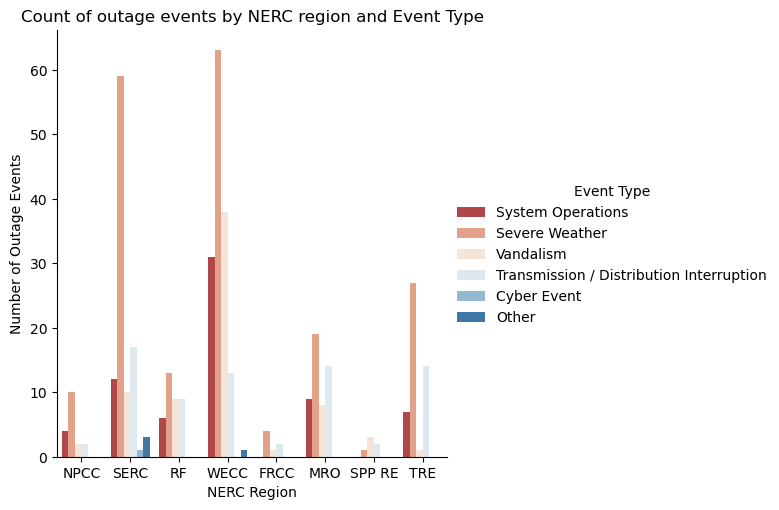

In [338]:
# Let's add another dimension to the histogram above by showing the event type by region
_ = sns.catplot(x = 'NERC Region', data = outage_df, kind = 'count', hue = 'Event Type', palette = 'RdBu')
plt.title('Count of outage events by NERC region and Event Type')
plt.ylabel('Number of Outage Events')
plt.show()

WECC seems much more likely than other regions to have system operation issues as well as vandalism events.  This could be interesting to explore.  Maybe WECC needs more investment to improve system operations and security to prevent vandalism.

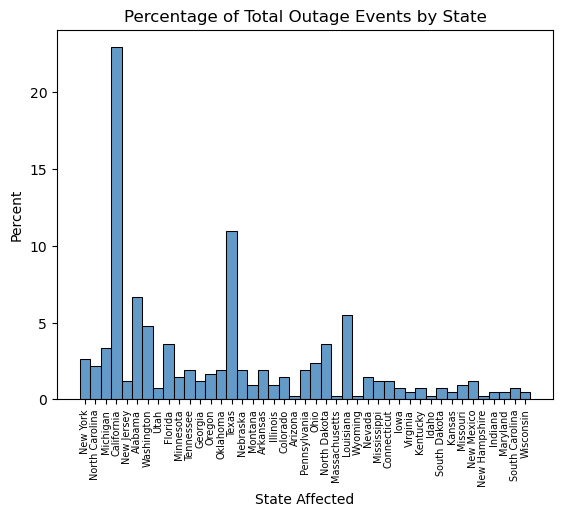

In [339]:
# Let's check if outages were more likely to happen in certain states
_ = sns.histplot(data = outage_df, x = 'State Affected', stat = 'percent')
plt.xticks(rotation = 90, fontsize = 7)
plt.title('Percentage of Total Outage Events by State')
plt.show()

California and Texas by far have the most outages.  This isn't totally surprising given their large geographic areas.  What is surprising is Alabama, Louisiana, Washington, and North Dakota have a surprising amount of outages.

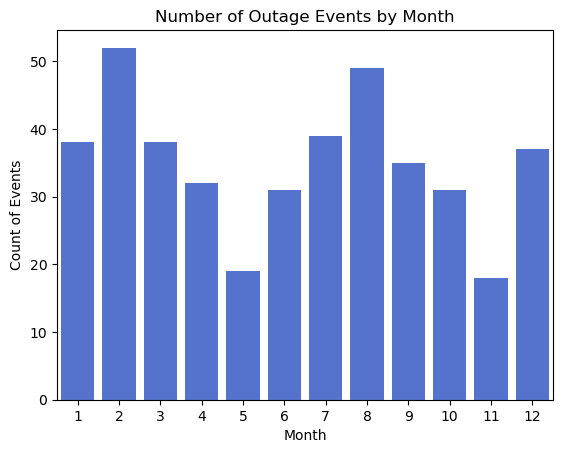

In [341]:
# Let's group the outages by month and see if certain months are more likely to have outages than others
monthly_counts = pd.DataFrame(outage_df.groupby(outage_df['Datetime Event Began'].dt.month)['Datetime Event Began'].count())
monthly_counts = monthly_counts.rename(columns = {'Datetime Event Began':'Count of Events'}).reset_index()
monthly_counts = monthly_counts.rename(columns = {'Datetime Event Began':'Month'})
_ = sns.barplot(x = 'Month', y = 'Count of Events', data = monthly_counts, color = 'royalblue')
plt.title('Number of Outage Events by Month')
plt.show()

There is some seasonality associated with outages.  There seem to be peaks in February (typically associated with cold winter weather) as well as August (typically associated with hot summer weather).  The mild seasons of spring and fall typically have fewer outages.

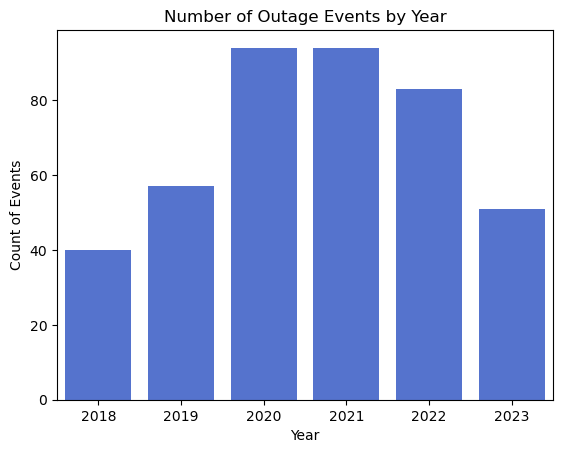

In [348]:
# Let's group the outages by year and see how the trend has been changing over time
annual_counts = pd.DataFrame(outage_df.groupby(outage_df['Datetime Event Began'].dt.year)['Datetime Event Began'].count())
annual_counts = annual_counts.rename(columns = {'Datetime Event Began':'Count of Events'}).reset_index()
annual_counts = annual_counts.rename(columns = {'Datetime Event Began':'Year'})

_ = sns.barplot(x = 'Year', y = 'Count of Events', data = annual_counts, color = 'royalblue')
plt.title('Number of Outage Events by Year')
plt.show()

Interestingly, 2020, 2021, and 2022 had significantly more outage events than the other years.  Maybe this could be due to stay at home orders and a corresponding shift in electrical energy demand?

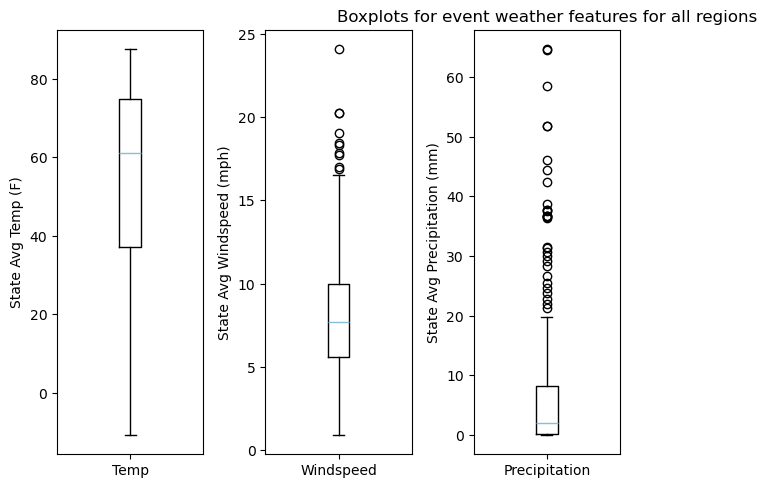

In [447]:
# Let's explore outages related to severe weather, system operations, and transmission interruptions and how they relate to weather related features
# Subset the outage_df to include only outages that are potentially weather related.  This would include event types of severe weather, system operations, and transmission / distribution interruptions
weather_related_outages_df = outage_df[outage_df['Event Type'].isin(['System Operations','Severe Weather','Transmission / Distribution Interruption'])].reset_index(drop = True)
weather_related_outages_df['Month'] = weather_related_outages_df['Datetime Event Began'].dt.month

# Create a boxplots of avg temp, windspeed and precipitation for these events
fig, ax = plt.subplots(1,3)
ax[0].boxplot(weather_related_outages_df['State Avg Temp (F)'])
ax[0].set_ylabel('State Avg Temp (F)')
ax[0].set_xticklabels(['Temp'])

ax[1].boxplot(weather_related_outages_df['State Avg Windspeed (mph)'])
ax[1].set_ylabel('State Avg Windspeed (mph)')
ax[1].set_xticklabels(['Windspeed'])

ax[2].boxplot(weather_related_outages_df['State Avg Precipitation (mm)'])
ax[2].set_ylabel('State Avg Precipitation (mm)')
ax[2].set_xticklabels(['Precipitation'])

fig.tight_layout()
plt.title('Boxplots for event weather features for all regions')
plt.show()

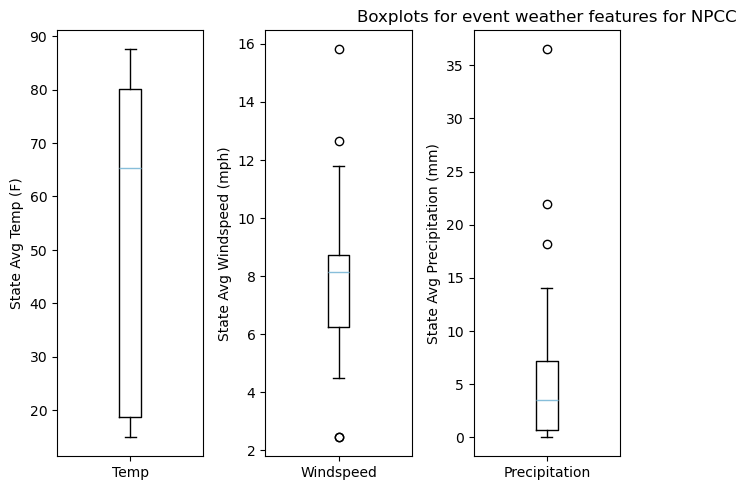

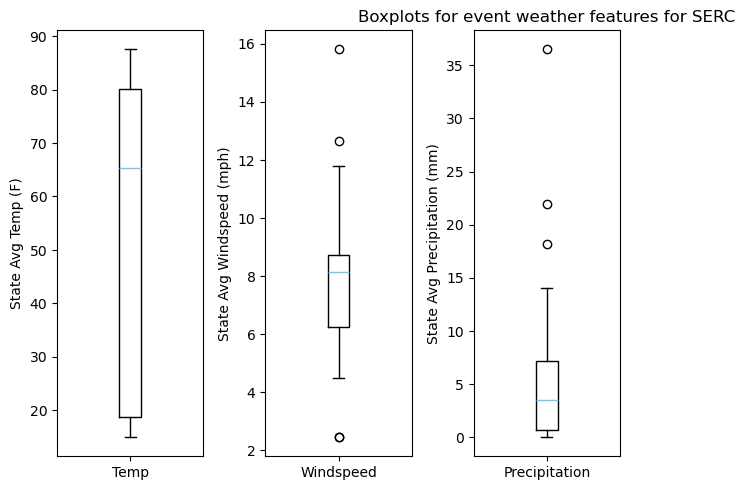

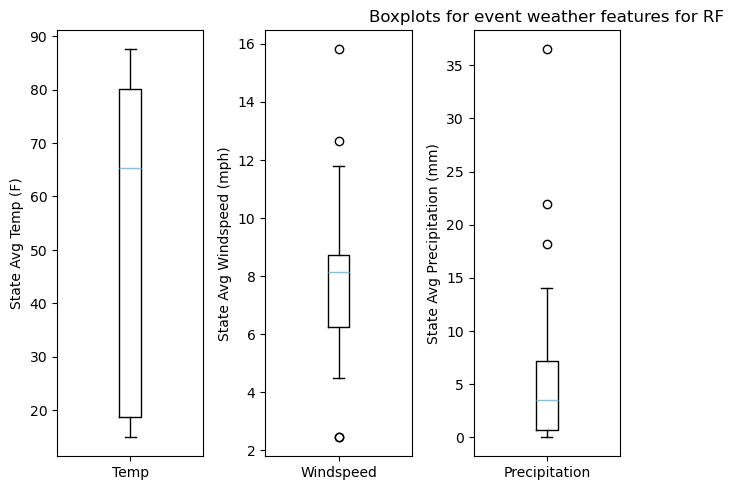

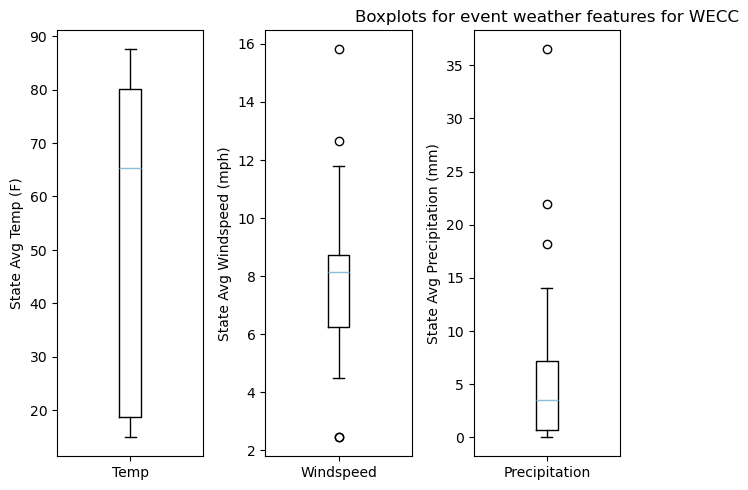

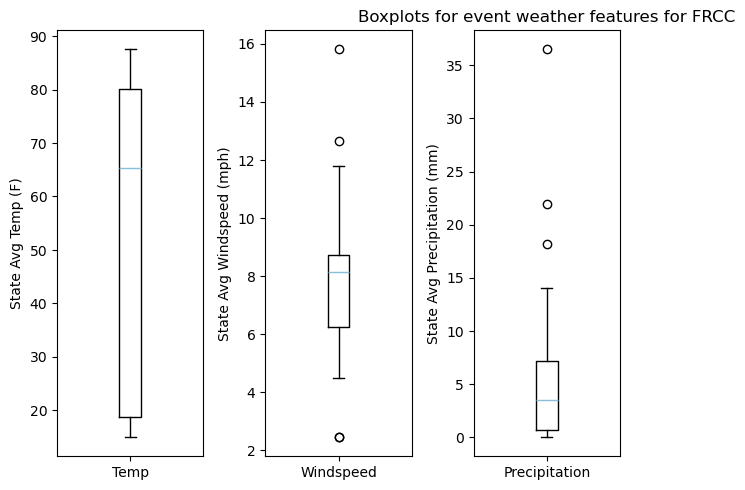

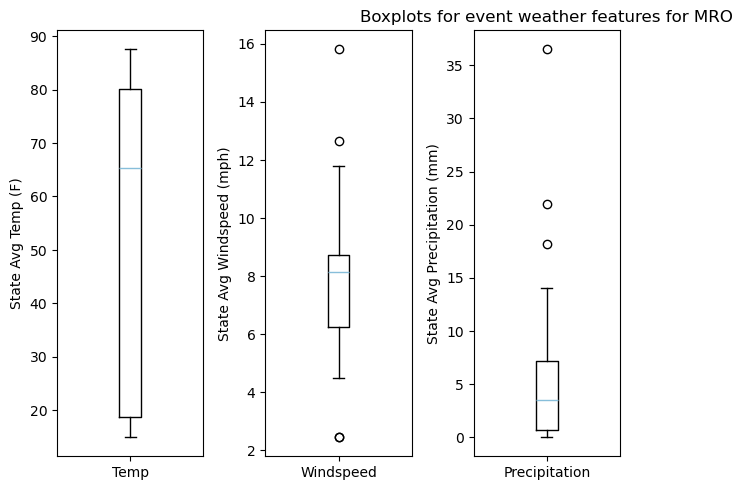

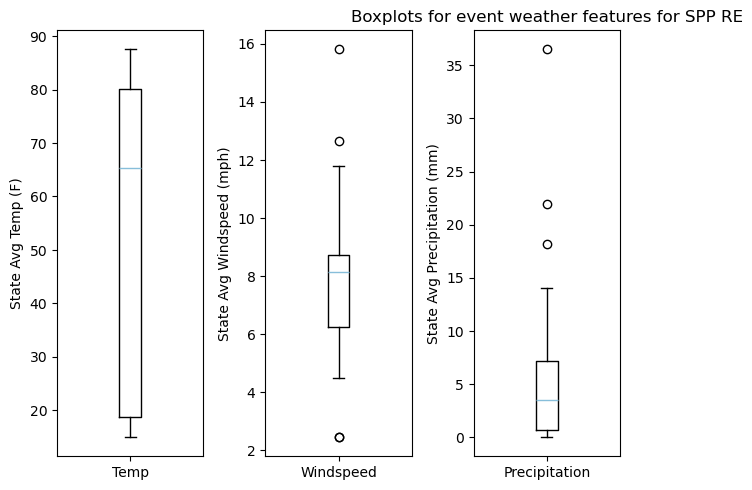

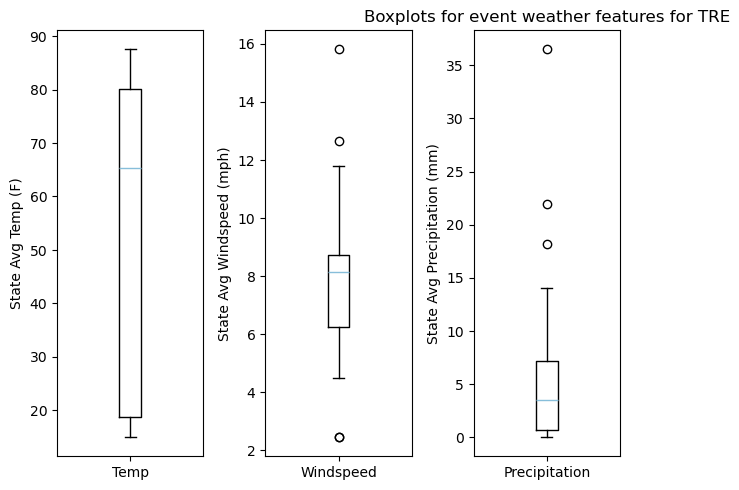

In [446]:
# Since the weather in the different NERC regions varies so widely it makes sense to view the above boxplots for each region
    
for region in outage_df['NERC Region'].unique():
    outage_df_by_region = outage_df[outage_df['NERC Region'] == region]
    # Subset the outage_df to include only outages that are potentially weather related.  This would include event types of severe weather, system operations, and transmission / distribution interruptions
    weather_related_outages_df_region = outage_df_by_region[outage_df_by_region['Event Type'].isin(['System Operations','Severe Weather','Transmission / Distribution Interruption'])].reset_index(drop = True)
    weather_related_outages_df_region['Month'] = weather_related_outages_df_region['Datetime Event Began'].dt.month
    
    # Create a boxplots of avg temp, windspeed and precipitation for these events
    fig, ax = plt.subplots(1,3)
    ax[0].boxplot(weather_related_outages_df['State Avg Temp (F)'])
    ax[0].set_ylabel('State Avg Temp (F)')
    ax[0].set_xticklabels(['Temp'])
    
    ax[1].boxplot(weather_related_outages_df['State Avg Windspeed (mph)'])
    ax[1].set_ylabel('State Avg Windspeed (mph)')
    ax[1].set_xticklabels(['Windspeed'])
    
    ax[2].boxplot(weather_related_outages_df['State Avg Precipitation (mm)'])
    ax[2].set_ylabel('State Avg Precipitation (mm)')
    ax[2].set_xticklabels(['Precipitation'])
    
    fig.tight_layout()
    plt.title(f'Boxplots for event weather features for {region}')
    plt.show()

There seem to be some interesting trends here.  A lot of the outages seem to occur at higher temperatures.  This may be due to increased demand on the electrical grid during high temperature times. When demand is near supply without extra capacity to bring online, a weather event is more likely to cause a significant outage.

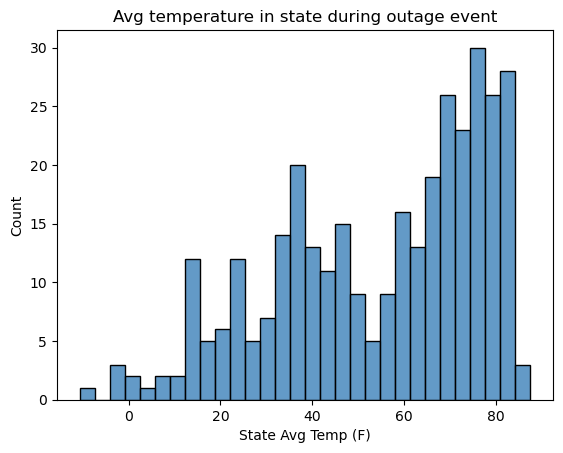

In [388]:
# Create a histogram of avg temp for these events

_ = sns.histplot(data = weather_related_outages_df, x = 'State Avg Temp (F)', bins = 30)
plt.title('Avg temperature in state during outage event')
plt.show()

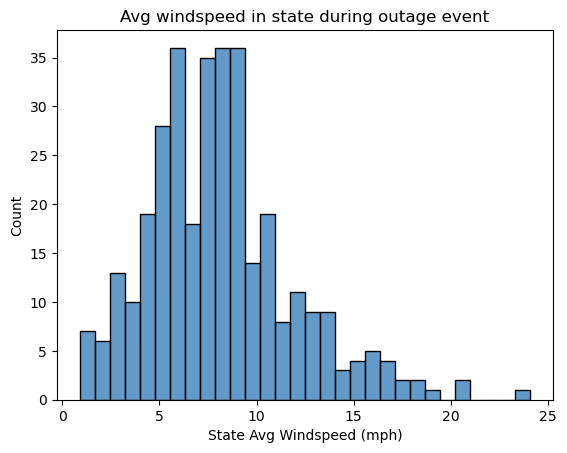

In [387]:
# Create a histogram of avg windspeed for these events

_ = sns.histplot(data = weather_related_outages_df, x = 'State Avg Windspeed (mph)', bins = 30)
plt.title('Avg windspeed in state during outage event')
plt.show()

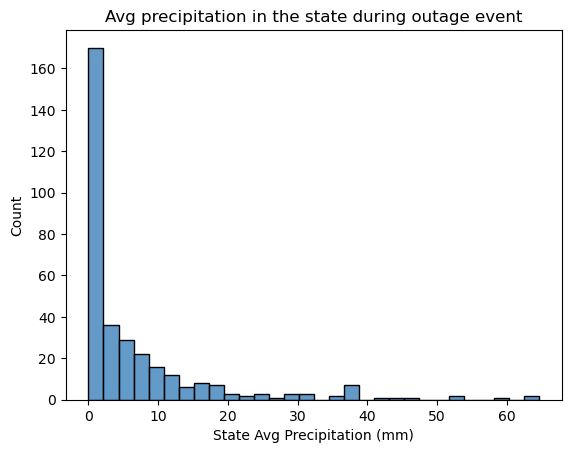

In [385]:
# Plot a histogram of the avg precipitaton during the outage event.

_ = sns.histplot(data = weather_related_outages_df, x = 'State Avg Precipitation (mm)', bins = 30)
plt.title('Avg precipitation in the state during outage event')
plt.show()

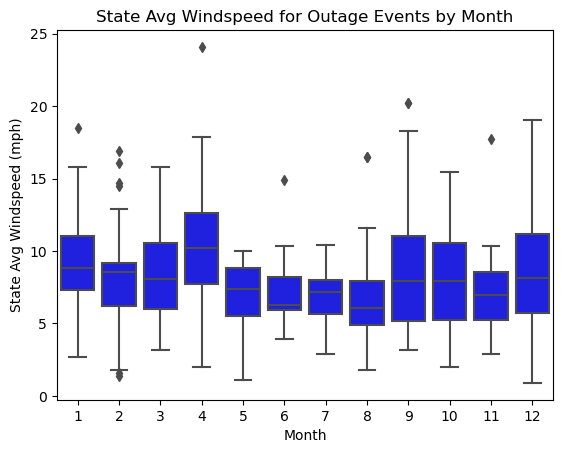

In [448]:
# Create a boxplot of avg windspeed for these events
_ = sns.boxplot(data = weather_related_outages_df, x = 'Month', y = 'State Avg Windspeed (mph)', color = 'b')
plt.title('State Avg Windspeed for Outage Events by Month')
plt.show()

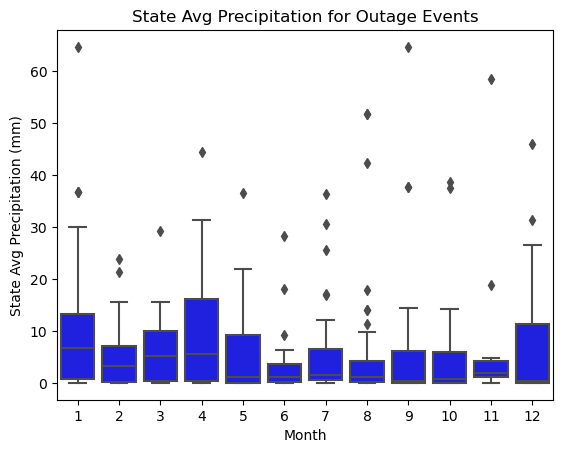

In [449]:
# Create a boxplot of avg precipitation for these events
_ = sns.boxplot(data = weather_related_outages_df, x = 'Month', y = 'State Avg Precipitation (mm)', color = 'b')
plt.title('State Avg Precipitation for Outage Events')
plt.show()

There are a lot more outlier values for precipitation.  It makes sense that when there is an extreme amount of precipitation, there is more likely to be an outage event.

The weather data doesn't seem to tell us all that much by itself.  I think it will be useful to import data related to the normals over the past 30 years of temp, windspeed, and precipitation.  It could be that when weather greatly exceeds the normal values there is more likely to be an outage event.  

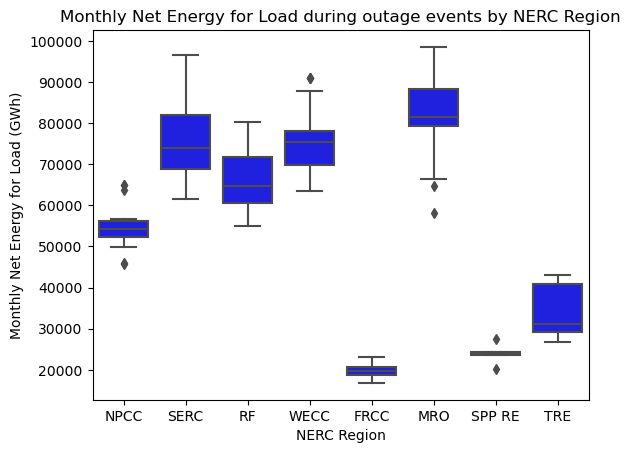

In [419]:
# Let's also look at boxplots by NERC region for Net Energy Load and Peak Hour Demand
_ = sns.boxplot(x = 'NERC Region', y = 'Monthly Net Energy for Load (GWh)', data = outage_df, color = 'b')
plt.title('Monthly Net Energy for Load during outage events by NERC Region')
plt.show()

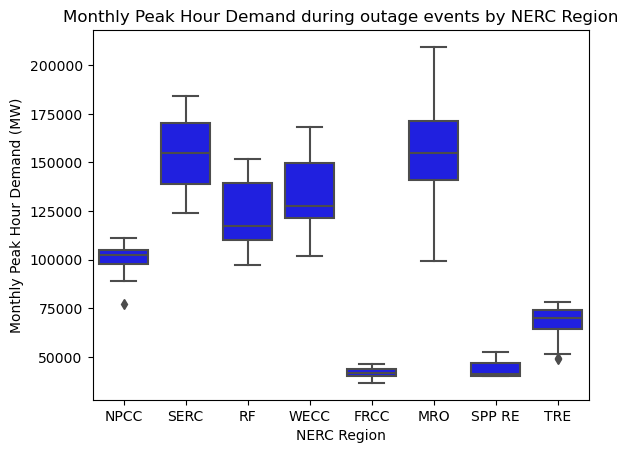

In [418]:
_ = sns.boxplot(x = 'NERC Region', y = 'Monthly Peak Hour Demand (MW)', data = outage_df, color = 'b')
plt.title('Monthly Peak Hour Demand during outage events by NERC Region')
plt.show()

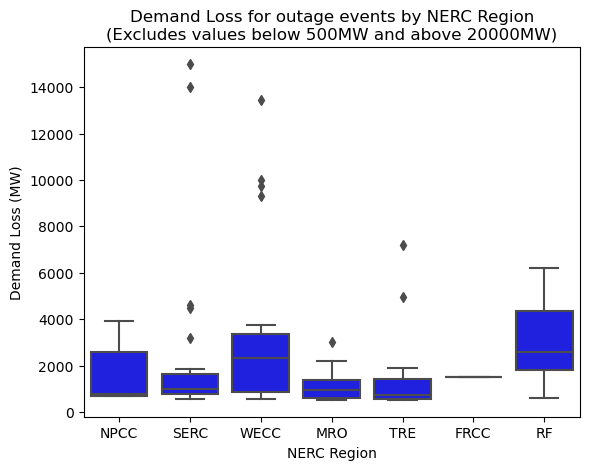

In [475]:
# Create a boxplot for demand loss
_ = sns.boxplot(data = outage_df[(outage_df['Demand Loss (MW)']>500)&(outage_df['Demand Loss (MW)']<20000)], x = 'NERC Region', y = 'Demand Loss (MW)', color = 'b')
plt.title('Demand Loss for outage events by NERC Region\n(Excludes values below 500MW and above 20000MW)')
plt.show()

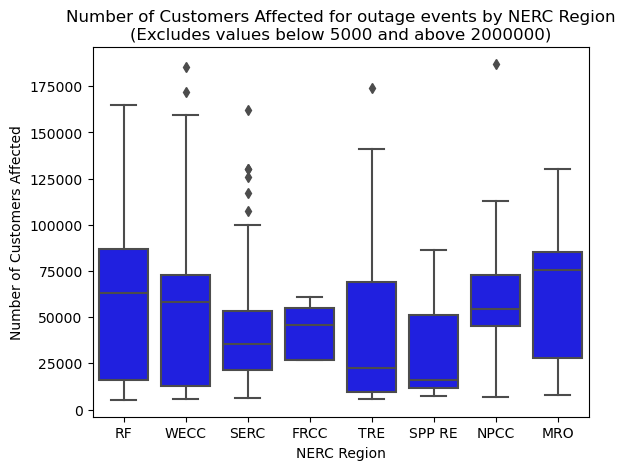

In [474]:
# Create a boxplot for number of customers affected
_ = sns.boxplot(data = outage_df[(outage_df['Number of Customers Affected']>5000)&(outage_df['Number of Customers Affected']<200000)], x = 'NERC Region', y = 'Number of Customers Affected', color = 'b')
plt.title('Number of Customers Affected for outage events by NERC Region\n(Excludes values below 5000 and above 2000000)')
plt.show()

Both the demand loss and number of customers affected are concentrated towards the lower end.  In both I had to exclude extreme values to facilitate visibility of the data.  SERC region seems to have more outliers at the high end of demand loss and number of customers affected.

### Incorporate normal weather data (avg of last 30 years for temp and precipitation)

In [424]:
# Load the FIPSID dictionary from the data wrangling notebook
import pickle

with open('keys.pickle', 'rb') as f:
    FIPSID_dict = pickle.load(f)

print(FIPSID_dict)

{'Alabama': 'FIPS:01', 'Alaska': 'FIPS:02', 'Arizona': 'FIPS:04', 'Arkansas': 'FIPS:05', 'California': 'FIPS:06', 'Colorado': 'FIPS:08', 'Connecticut': 'FIPS:09', 'Delaware': 'FIPS:10', 'District of Columbia': 'FIPS:11', 'Florida': 'FIPS:12', 'Georgia': 'FIPS:13', 'Hawaii': 'FIPS:15', 'Idaho': 'FIPS:16', 'Illinois': 'FIPS:17', 'Indiana': 'FIPS:18', 'Iowa': 'FIPS:19', 'Kansas': 'FIPS:20', 'Kentucky': 'FIPS:21', 'Louisiana': 'FIPS:22', 'Maine': 'FIPS:23', 'Maryland': 'FIPS:24', 'Massachusetts': 'FIPS:25', 'Michigan': 'FIPS:26', 'Minnesota': 'FIPS:27', 'Mississippi': 'FIPS:28', 'Missouri': 'FIPS:29', 'Montana': 'FIPS:30', 'Nebraska': 'FIPS:31', 'Nevada': 'FIPS:32', 'New Hampshire': 'FIPS:33', 'New Jersey': 'FIPS:34', 'New Mexico': 'FIPS:35', 'New York': 'FIPS:36', 'North Carolina': 'FIPS:37', 'North Dakota': 'FIPS:38', 'Ohio': 'FIPS:39', 'Oklahoma': 'FIPS:40', 'Oregon': 'FIPS:41', 'Pennsylvania': 'FIPS:42', 'Rhode Island': 'FIPS:44', 'South Carolina': 'FIPS:45', 'South Dakota': 'FIPS:46',

In [434]:
# Let's import additional weather data relating to the normal values of temperature and precipitation
# These values are the average temperature and median precipitation for the specific state from the years 1991 - 2020 during the month of the associated event

# The code below pulls the NOAA API token from a local .env file.  API token can be requested here: https://www.ncdc.noaa.gov/cdo-web/token
from dotenv import load_dotenv
load_dotenv()
token = os.getenv('NOAA_token')
# print(token) # This checks that the token was pulled correctly

# Setting a variable "header" equal to the token to be included in the GET request
headers = {"token": token}

# Setting request parameters to pull relevant weather data from the API.
dataset_id = "NORMAL_DLY" # This id corresponds to the data set with the normal daily weather observations from 1991-2020. Documentation for this dataset is here: https://www.ncei.noaa.gov/pub/data/cdo/documentation/NORMAL_DLY_documentation.pdf

# Below are the datatype ids of the specific observations I would like to pull from each event
tavg_normal_id = 'dly-tavg-normal' # returns Long-term averages of daily average temperature
precip_normal_id = 'dly-prcp-50pctl' # 50th percentiles of daily nonzero precipitation totals for 29-day windows centered on each day of the year

# Create a function to pull these normal values
def weather_data_request_normals(event_index):
    
    '''
    This function will issue a request to the NOAA CDO API for the four parameters described for a specific event in the outage_df.
    The only argument/parameter needed is the associated index number from the outage_df dataset above.
    '''
    
    start_date = outage_df['Datetime Event Began'][event_index].date()   # This will pull the start date from the outage dataset
    end_date = start_date                                                # The end date should correspond to the start date because we are only interested in the weather at the time the outage occurred
    location_id = FIPSID_dict[outage_df['State Affected'][event_index]]  # This pulls the affected state from the outage_df and the associated FIPSID from the FIPSID_dict
    url_3 = f"https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid={dataset_id}&locationid={location_id}&startdate={start_date}&enddate={end_date}&datatypeid={tavg_normal_id}&units='standard'&limit=1000"

    r_3 = requests.get(url_3, headers = headers)
    # print(r_3)
    if r_3.text.strip():
        json_data_3 = r_3.json()
        dict_data_3 = dict(json_data_3)
        print(dict_data_3)
        if dict_data_3 == {}:
            return 'No Data'
        else:
            normal_avg_temp_in_F = statistics.mean([dict['value'] for dict in dict_data_3['results'] if dict['datatype']=='TAVG'])
    else:
        return 'No Data'


https://www.ncei.noaa.gov/cdo-web/api/v2/data?datasetid=NORMAL_DLY&locationid=FIPS:06&startdate=2018-02-08&enddate=2018-02-08&datatypeid=dly-prcp-50pctl&limit=1000


### Continue EDA

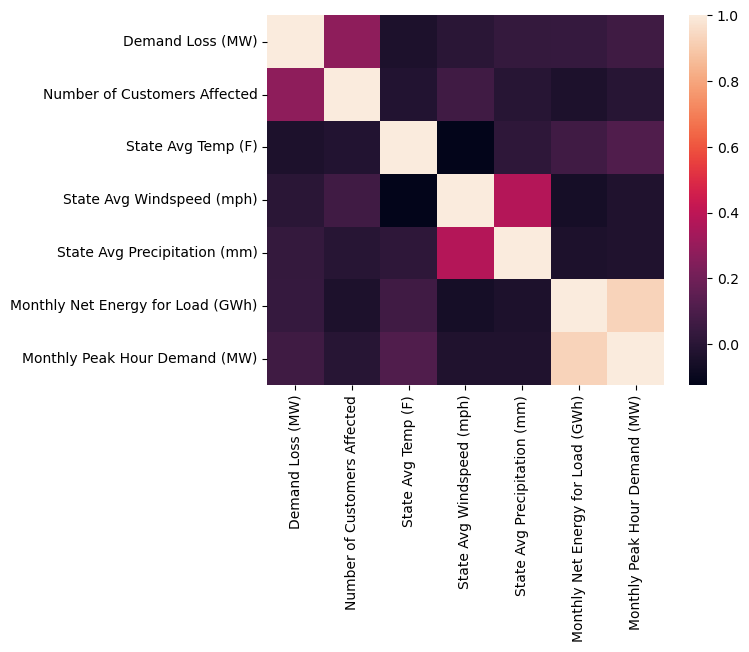

In [440]:
# Let's see how the numeric columns correlate with each other and visualize it in a heatmap
outage_df_numeric = outage_df.iloc[:,5:]
corr_matrix = outage_df_numeric.corr()
_ = sns.heatmap(corr_matrix)
plt.show()

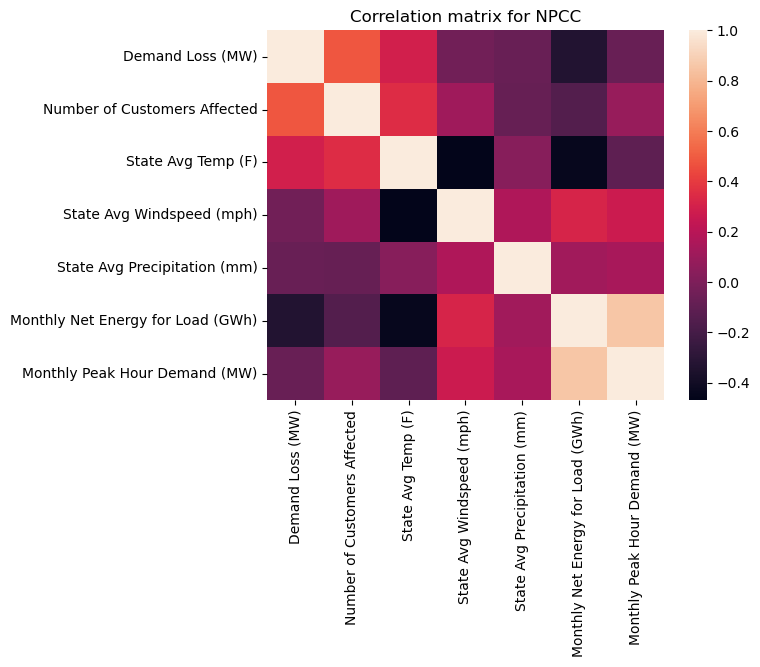

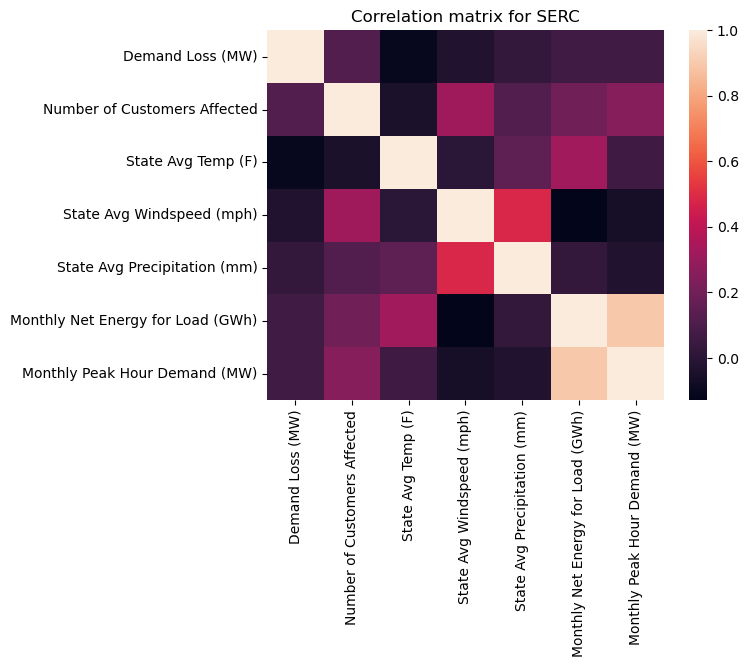

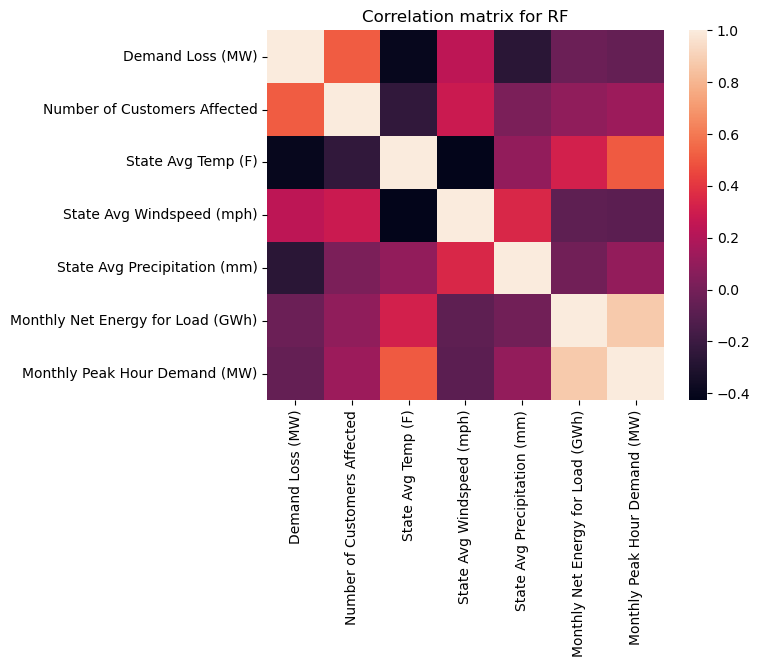

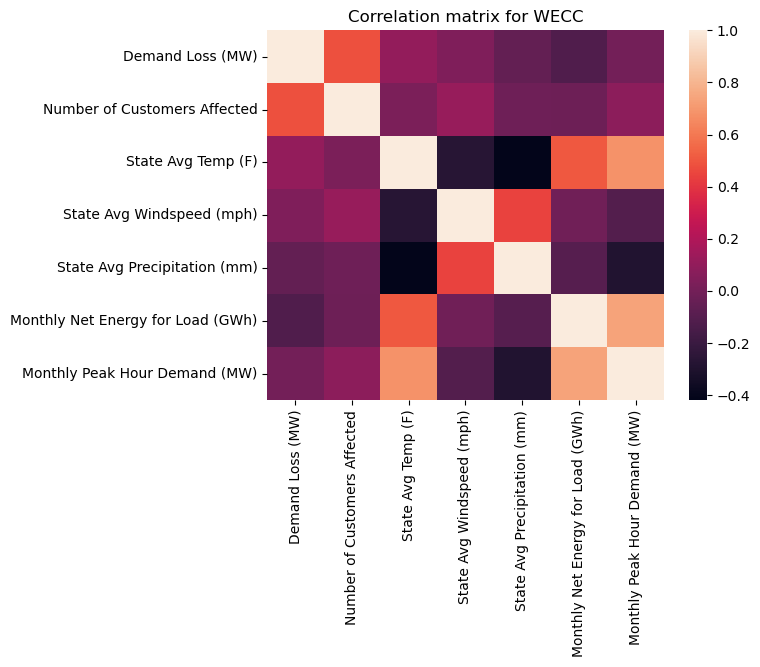

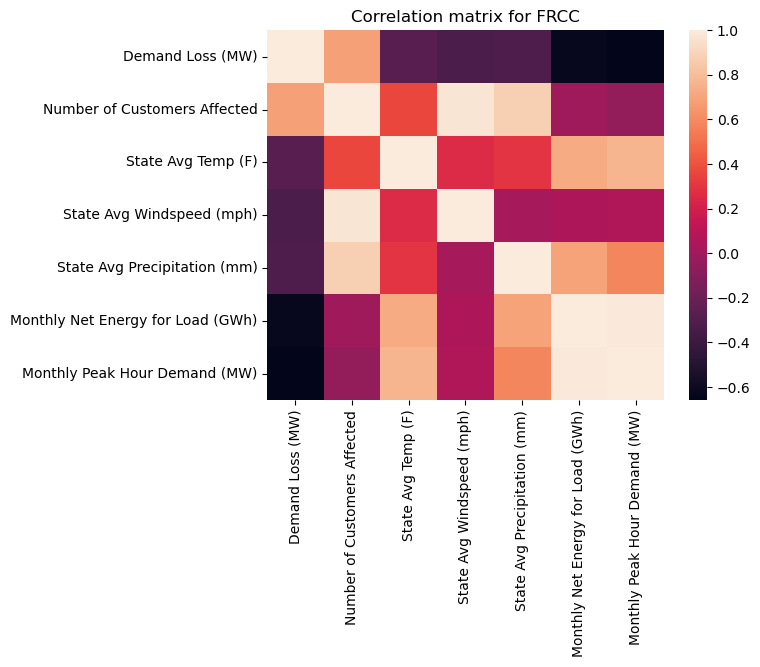

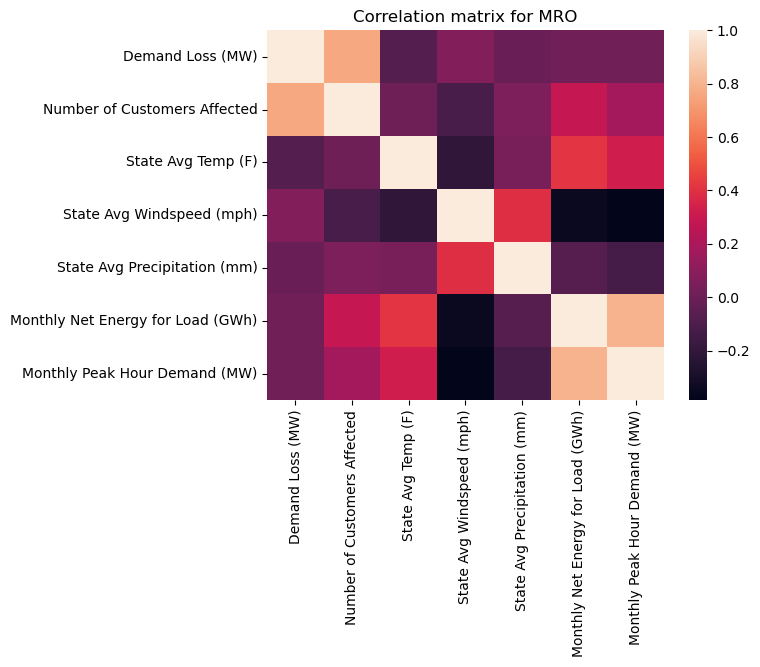

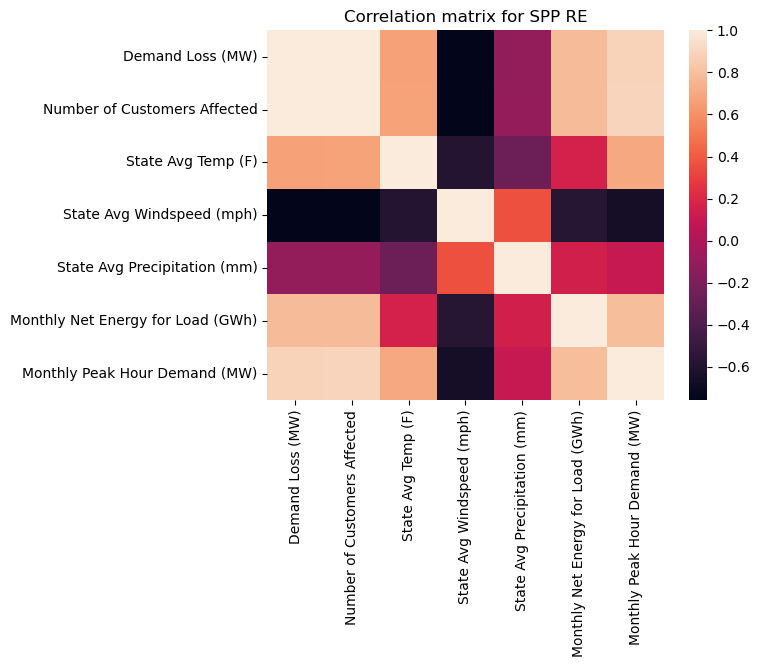

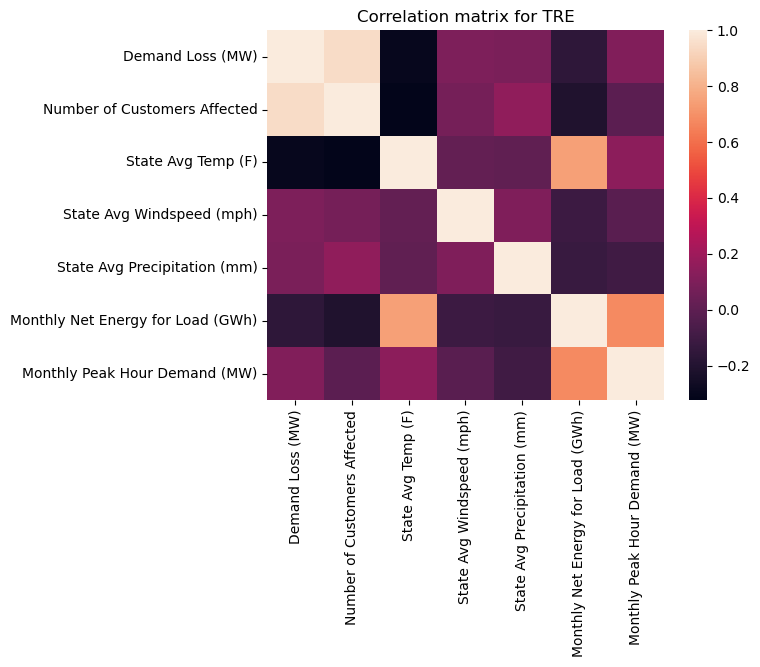

In [442]:
# Let's group the dataset by region and run the correlation matrix / heatmap for each region separately

for region in outage_df['NERC Region'].unique():
    outage_df_by_region = outage_df[outage_df['NERC Region'] == region]
    outage_df_numeric = outage_df_by_region.iloc[:,5:]
    corr_matrix = outage_df_numeric.corr()
    _ = sns.heatmap(corr_matrix)
    plt.title(f'Correlation matrix for {region}')
    plt.show()

The correlation matrix provides a lot more insight when broken out by region. This is because each region has vastly different weather patterns and population (causing more or less energy demand).  

The following features seem to be consistently highly correlated:
* Monthly net energy for load and monthly peak hour demand: this makes sense as power generators bring on more supply as demand increases
* Avg temp and peak hour demand: This is also expected as higher temperatures require more energy to run air conditioning units
* Avg windspeed and precipitation: It seems as if precipitation storms also bring higher windspeeds
* Demand loss and number of customers affected: As more demand is lost, more customers will lose power

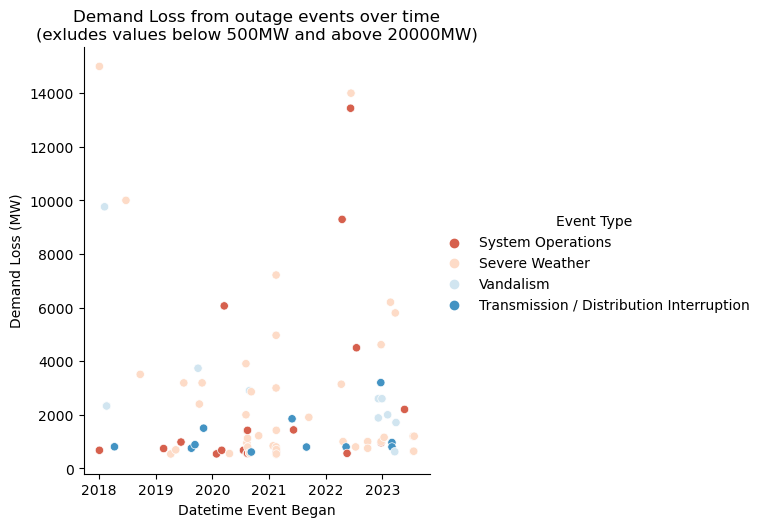

In [489]:
# Let's also explore how these parameters changed over time.  We'll create a timeseries lineplot showing the various features and how they changed over time

# There are quite a few events with demand loss near or at 0, and a couple of large outliers.  I will plot demand loss filtering these extreme values out.
_ = sns.relplot(kind = 'scatter', x = 'Datetime Event Began', y = 'Demand Loss (MW)', hue = 'Event Type', data = outage_df[(outage_df['Demand Loss (MW)'] < 20000) & (outage_df['Demand Loss (MW)'] > 500)], palette = 'RdBu',markers = True, dashes = False)
plt.title('Demand Loss from outage events over time\n(exludes values below 500MW and above 20,000MW)')
plt.show()

No trends jump out when looking at demand loss over time.

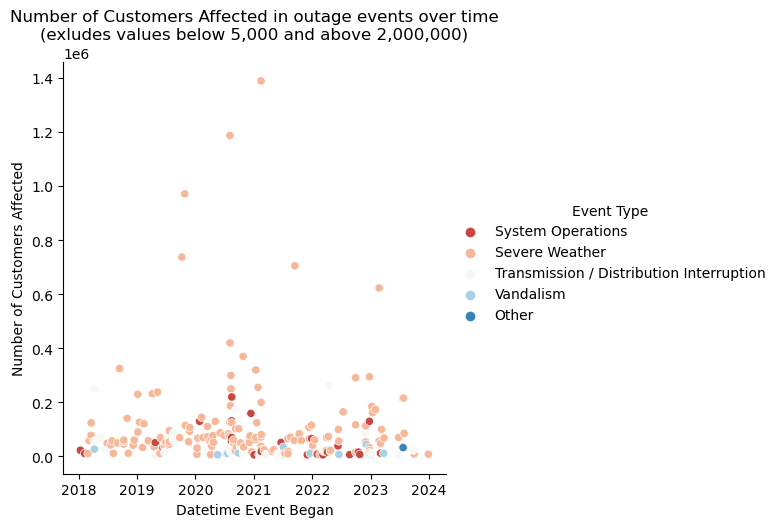

In [491]:
# Create a timeseries plot of Number of Customers Affected
_ = sns.relplot(kind = 'scatter', x = 'Datetime Event Began', y = 'Number of Customers Affected', data = outage_df[(outage_df['Number of Customers Affected'] < 2000000) & (outage_df['Number of Customers Affected'] > 5000)], hue = 'Event Type', palette= 'RdBu',markers = True, dashes = False)
plt.title('Number of Customers Affected in outage events over time\n(exludes values below 5,000 and above 2,000,000)')
plt.show()

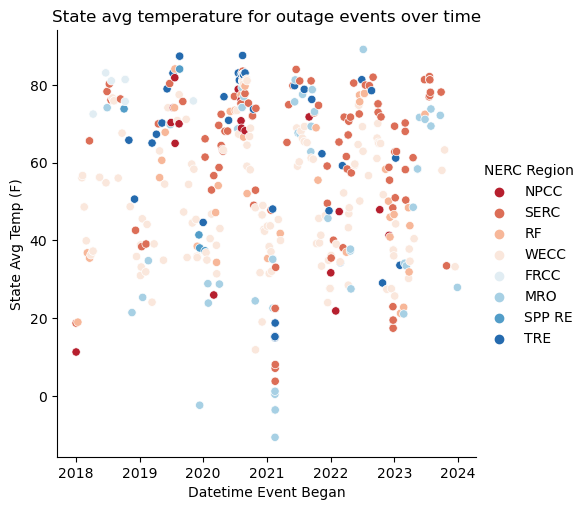

In [498]:
# Create a timeseries plot of the remaining numerical variables
# Timeseries plot for state avg temp
_ = sns.relplot(kind = 'scatter', x = 'Datetime Event Began', y = 'State Avg Temp (F)', data = outage_df, hue = 'NERC Region', palette= 'RdBu',markers = True, dashes = False)
plt.title('State avg temperature for outage events over time')
plt.show()

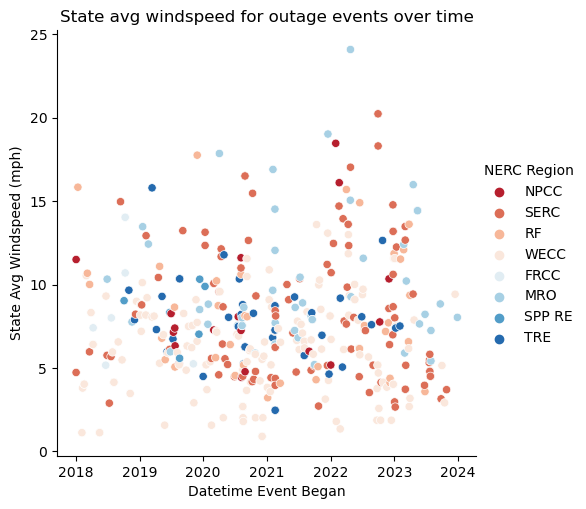

In [499]:
# Timeseries plot for state avg windspeed
_ = sns.relplot(kind = 'scatter', x = 'Datetime Event Began', y = 'State Avg Windspeed (mph)', data = outage_df, hue = 'NERC Region', palette= 'RdBu',markers = True, dashes = False)
plt.title('State avg windspeed for outage events over time')
plt.show()

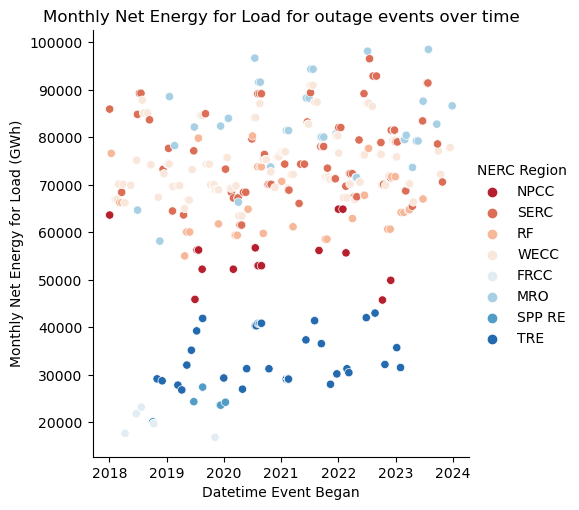

In [500]:
# Timeseries plot for Net Energy for Load
_ = sns.relplot(kind = 'scatter', x = 'Datetime Event Began', y = 'Monthly Net Energy for Load (GWh)', data = outage_df, hue = 'NERC Region', palette= 'RdBu',markers = True, dashes = False)
plt.title('Monthly Net Energy for Load for outage events over time')
plt.show()

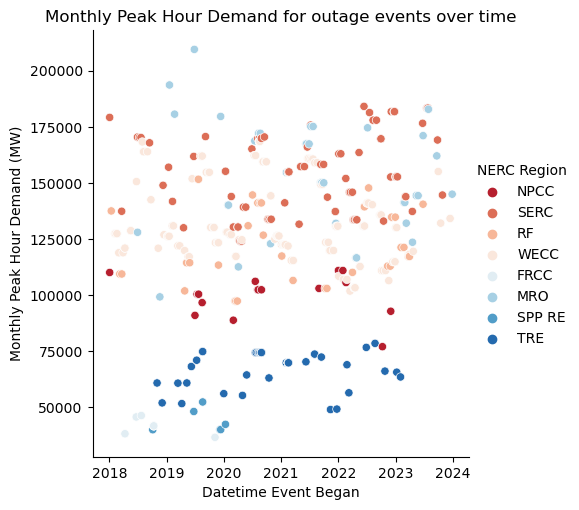

In [501]:
# Timeseries plot for Peak Hour Energy Demand
_ = sns.relplot(kind = 'scatter', x = 'Datetime Event Began', y = 'Monthly Peak Hour Demand (MW)', data = outage_df, hue = 'NERC Region', palette= 'RdBu',markers = True, dashes = False)
plt.title('Monthly Peak Hour Demand for outage events over time')
plt.show()

## Summary

In this notebook I accomplished the following tasks:
* incorporated new energy demand and supply data for each outage event.  This data relates to the monthly values for supply and demand for each outage event.  While it is not as specific as the previous data (that data related to the specific day of the outage event) it is more complete and has no null values (compared to over 100 from the previous data set).
* There were some missing values for weather data for Texas, Colorado, and California.  I obtained new data from the API and incorporated that data into the dataframe.
* I cleaned the data a bit more to make the event type categories more succint and consistent
* I made the following visualizations:
  1. **Histogram of outage events by event type:** the main culprit of outage events seems to be weather issues
  2. **Histogram of outage events by NERC Region:** WECC accounts for nearly 35% of all outages...perhaps this isn't surprising since it makes up a vast geographic area
  3. **Histogram of outage events by NERC Region/Event Type:** WECC seems much more likely than other regions to have system operation issues as well as vandalism events. This could be interesting to explore. Maybe WECC needs more investment to improve system operations and security to prevent vandalism.
  4. **Countplot of outage events by state:** California and Texas by far have the most outages. This isn't totally surprising given their large geographic areas. What is surprising is Alabama, Louisiana, Washington, and North Dakota have a surprising amount of outages.
  5. **Countplot of outage events by month:** There is some seasonality associated with outages. There seem to be peaks in February (typically associated with cold winter weather) as well as August (typically associated with hot summer weather). The mild seasons of spring and fall typically have fewer outages.
  6. **Countplot of outage events by year:**  Interestingly, 2020, 2021, and 2022 had significantly more outage events than the other years. Maybe this could be due to stay at home orders and a corresponding shift in electrical energy demand?
  7. **Boxplots for weather features by NERC region:** There seem to be some interesting trends here.  A lot of the outages seem to occur at higher temperatures.  This may be due to increased demand on the electrical grid during high temperature times. When demand is near supply without extra capacity to bring online, a weather event is more likely to cause a significant outage.
  8. **Boxplots for energy supply and demand by region:** Both the demand loss and number of customers affected are concentrated towards the lower end.  In both I had to exclude extreme values to facilitate visibility of the data.  SERC region seems to have more outliers at the high end of demand loss and number of customers affected.
  9. **Correlation heatmaps for numeric features:** The correlation matrix provides a lot more insight when broken out by region. This is because each region has vastly different weather patterns and population (causing more or less energy demand).  
        The following features seem to be consistently highly correlated:
        * Monthly net energy for load and monthly peak hour demand: this makes sense as power generators bring on more supply as demand increases
        * Avg temp and peak hour demand: This is also expected as higher temperatures require more energy to run air conditioning units
        * Avg windspeed and precipitation: It seems as if precipitation storms also bring higher windspeeds
        * Demand loss and number of customers affected: As more demand is lost, more customers will lose power
  10. **Timeseries plots for numeric features:** No major trends jump out.
 
As next steps, I would like to incorporate weather data related to the normal values of temperature and precipitation for the last 30 years in the affected state of each event.  It is possible that when these weather features deviate significantly from the normal value, that could be a predictor of an outage event.  I attempted to download the normal data, but it seemed as if there were many null values.  I will continue to try to obtain this information and if I am succesful in downloading it, I will incorporate it into the data set.
  

In [467]:
outage_df

,Datetime Event Began,State Affected,NERC Region,Alert Criteria,Event Type,Demand Loss (MW),Number of Customers Affected,State Avg Temp (F),State Avg Windspeed (mph),State Avg Precipitation (mm),Monthly Net Energy for Load (GWh),Monthly Peak Hour Demand (MW)
0,2018-01-02 10:00:00,New York,NPCC,Fuel supply emergencies that could impact elec...,System Operations,675.0,NaN,11.261429,11.499064,0.811386,63641.527716,110050.900000
1,2018-01-02 06:45:00,North Carolina,SERC,System-wide voltage reductions of 3 percent or...,Severe Weather,14998.0,NaN,18.694595,4.726667,0.000424,85958.000000,179134.000000
2,2018-01-12 13:08:00,Michigan,RF,Cyber event that causes interruptions of elect...,System Operations,41.0,23007.0,18.944706,15.835709,8.174586,76640.000000,137465.000000
3,2018-02-04 13:42:00,California,WECC,Physical attack that could potentially impact ...,Vandalism,9760.0,0.0,56.094913,1.118450,0.005626,66930.133379,127365.022436
4,2018-02-08 13:25:00,California,WECC,Electrical System Separation (Islanding) where...,System Operations,30.0,10900.0,56.660645,3.791818,0.001110,66930.133379,127365.022436
...,...,...,...,...,...,...,...,...,...,...,...,...
414,2023-09-20 12:41:00,Oklahoma,MRO,Damage or destruction of a Facility within its...,NaN,51.0,NaN,72.140000,8.835755,5.993817,82787.594675,161995.921071
415,2023-10-15 07:16:00,California,WECC,"Unexpected Transmission loss within its area, ...",Other,72.0,6.0,63.246737,2.907970,0.038678,72217.336389,132030.087504
416,2023-10-26 12:41:00,Oregon,SERC,"Unexpected Transmission loss within its area, ...",Other,140.0,0.0,33.440000,3.695359,5.097192,70603.000000,144551.000000
417,2023-12-14 10:45:00,North Dakota,WECC,"Unexpected Transmission loss within its area, ...",NaN,20.0,1.0,33.195714,9.417349,0.004202,77873.145411,134110.475176
